# DIPY Tutorial - Multi-shell reconstructions

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from dipy.sims.voxel import multi_tensor, multi_tensor_odf
from dipy.data import get_sphere
from dipy.core.sphere import disperse_charges, Sphere, HemiSphere
from dipy.core.gradients import gradient_table

from fury import window, actor, io

from IPython.core.display import Image
from PIL import Image as PILImage
import os


In [3]:
# helper functions for visualization
WINDOW_SIZE = (400, 400)
SAVEIM_FOLDER = 'images'
if not os.path.exists(SAVEIM_FOLDER):
    os.mkdir(SAVEIM_FOLDER)

def screenshot_animated_sf(sf, sphere, rot=True, norm=True, scale=True, title='Modeling', theta_step=30):
    """
    Render a spherical function to file. Returns path to image.
    """
    scene = window.Scene()
    scene.background(window.colors.white)

    sf_actor = actor.odf_slicer(sf[None, None, None, :],
                                sphere=sphere, colormap='jet',
                                norm=norm, radial_scale=scale)
    if rot :
        sf_actor.RotateX(90)
    scene.add(sf_actor)

    images = []
    n_frames = 360//theta_step
    for i in np.arange(n_frames):
        sf_actor.RotateX(theta_step)
        scene.reset_clipping_range()
        images.append(PILImage.fromarray(window.snapshot(scene, size=WINDOW_SIZE)))
    
    frame_duration = 15000 // theta_step
    filename = os.path.join(SAVEIM_FOLDER, '{0}.gif'.format(title))
    images[0].save(filename, save_all=True, append_images=images[1:],
                   duration=frame_duration, optimize=False, loop=0)
    scene.clear()

    return filename

def screenshot_fodf_grid(sf, sphere, rot=True, norm=False, scale=True, bg=None, title="Modeling"):
    scene = window.Scene()
    scene.background(window.colors.white)
    sf_actor = actor.odf_slicer(sf[:], sphere=sphere, colormap='jet',
                                norm=norm, radial_scale=scale)

    if rot :
        sf_actor.RotateX(90)
    scene.add(sf_actor)

    if bg is not None:
        bg_actor = actor.slicer(bg, interpolation="nearest")
        scene.add(bg_actor)

    filename = os.path.join(SAVEIM_FOLDER, '{0}.png'.format(title))
    window.snapshot(scene, fname=filename, size=WINDOW_SIZE)

    scene.rm(sf_actor)
    if bg is not None:
        scene.rm(bg_actor)
    scene.clear()

    return filename

def screenshot_gradients(bvals, bvecs, b0s_mask, point_radius=0.05, title='Modeling'):
    n_b0 = np.sum(bvals==0)
    n_b300 = np.sum(bvals==300)
    n_b1000 = np.sum(bvals==1000)
    n_b2000 = np.sum(bvals==2000)

    colors_b300 = window.colors.red * np.ones((n_b300,3))
    colors_b1000 = window.colors.blue * np.ones((n_b1000,3))
    colors_b2000 = window.colors.cyan * np.ones((n_b2000,3))
    colors = np.vstack((colors_b300, colors_b1000, colors_b2000))
    colors = np.ascontiguousarray(colors)

    scene = window.Scene()
    scene.background(window.colors.white)
    pts_actor = actor.point(bvecs[~b0s_mask], colors, point_radius=point_radius)
    scene.add(pts_actor)

    filename = os.path.join(SAVEIM_FOLDER, '{0}.png'.format(title))
    window.snapshot(scene, fname=filename, size=WINDOW_SIZE)

    scene.rm(pts_actor)
    scene.clear()

    return filename

def screenshot_grid_with_captions(sfs, sphere, list_captions, rot=True, norm=True, scale=True, title="Modeling"):
    nb_sf = sfs.shape[0]
    actors = []
    actor_captions = []
    scene = window.Scene()
    scene.background(window.colors.white)

    for i in range(nb_sf):
        sf_actor = actor.odf_slicer(sfs[i, None, None, None, :], sphere=sphere, colormap='jet',
                                    norm=norm, radial_scale=scale)
        cap_actor = actor.label(list_captions[i], scale=(0.4,0.4,0.4), color=(0, 0, 0))
        if rot :
            sf_actor.RotateX(90)
        actors.append(sf_actor)
        actor_captions.append(cap_actor)

    actor_grid = actor.grid(actors,
                            captions=actor_captions,
                            caption_offset=(-1, 2.3, 0),
                            cell_shape='square',
                            cell_padding=1)
    scene.add(actor_grid)

    filename = os.path.join(SAVEIM_FOLDER, '{0}.png'.format(title))
    im = window.snapshot(scene, size=WINDOW_SIZE)
    io.save_image(im[::-1], filename)
    scene.clear()

    return filename

## Generating a gradient table
First, let's construct a gradient table for our multi-shell signal.

In [4]:
n_pts = 64
bvalue = 1000
S0 = 1000
SNR = 100

grad = np.loadtxt('grad-multi-shell-100dirs.txt')
# Sorting gradients by shell, to ensure correct color assignment.
grad = grad[grad[:, 3].argsort()]
bvals = grad[:,3]
bvecs = grad[:,0:3]
print(bvals)

gtab = gradient_table(bvals, bvecs)

n_b0 = np.sum(bvals==0)
n_b300 = np.sum(bvals==300)
n_b1000 = np.sum(bvals==1000)
n_b2000 = np.sum(bvals==2000)
print('Number of b=0 images', n_b0)
print('Number of b=300 images', n_b300)
print('Number of b=1000 images', n_b1000)
print('Number of b=2000 images', n_b2000)

[   0.    0.    0.    0.    0.    0.    0.  300.  300.  300.  300.  300.
  300.  300.  300. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.]
Number of b=0 images 7
Number of b=300 images 8
Number of b=1000 images 32
Number of b=2000 images 60


We can visualize the gradients distribution per shell.

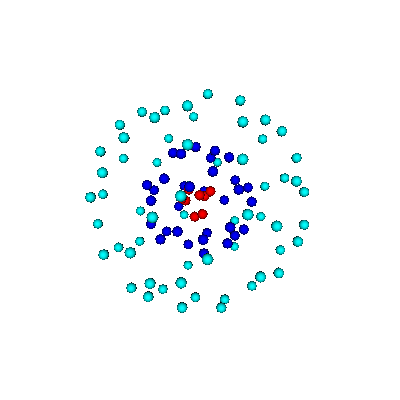

In [5]:
image = screenshot_gradients(bvals, gtab.gradients, gtab.b0s_mask, point_radius=100,
                             title='Multi-shell gradients distribution per shell')
Image(filename=image)

We can also visualize the overall gradients distribution.

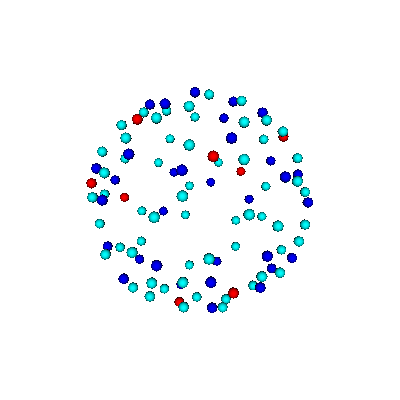

In [6]:
image = screenshot_gradients(bvals, gtab.bvecs, gtab.b0s_mask, point_radius=0.05,
                             title='Multi-shell gradients distribution, overall')
Image(filename=image)

## Simulating the signal
We now simulate a diffusion signal for 5 voxels.

In [7]:
# Configure the first voxel signal for 1, 2 or 3 fiber populations.
# This signal will be reused for the second section of this notebook.
N = 2
if N == 1 :
    mevals = np.array([[0.0015, 0.0004, 0.0004]])
    angles = [(0, 0)]
    fractions = [100]
if N == 2 :
    mevals = np.array([[0.0015, 0.0004, 0.0004],
                       [0.0015, 0.0004, 0.0004]])
    angles = [(0, 0), (90, 0)]
    fractions = [50, 50]
if N == 3:
    mevals = np.array([[0.0015, 0.0004, 0.0004],
                       [0.0004, 0.0015, 0.0004],
                       [0.0004, 0.0004, 0.0015]])
    angles = [(0, 0), (90, 0), (0,90)]
    fractions = [33, 33, 34]

signal, sticks = multi_tensor(gtab, mevals, S0=S0, angles=angles,
                              fractions=fractions, snr=SNR)

# GM voxel
evals_gm = np.array([[0.0004, 0.0004, 0.0004]])
S0_gm = 1500
fractions = [100]
signal_gm, sticks_gm = multi_tensor(gtab, evals_gm, S0=S0_gm,
                                    fractions=fractions, snr=SNR)

# CSF voxel
evals_csf = np.array([[0.003, 0.003, 0.003]])
S0_csf = 4000
fractions = [100]
signal_csf, sticks_csf = multi_tensor(gtab, evals_csf, S0=S0_csf,
                                      fractions=fractions, snr=SNR)

# Single WM voxel
evals_wm1 = np.array([[0.0015, 0.0003, 0.0003]])
angles = [(90, 0)]
fractions = [100]
signal_wm1, sticks_wm1 = multi_tensor(gtab, evals_wm1, S0=S0, angles=angles,
                                      fractions=fractions, snr=SNR)

# WM-GM voxel
evals_wm_gm = np.array([[0.0015, 0.0003, 0.0003],
                        [0.0004, 0.0004, 0.0004]])
angles = [(90, 0), (0, 0)]
fractions = [50, 50]
S0_wm_gm = S0 # normaly should be [S0, S0_gm] but multi_tensor doesn't allow it
signal_wm_gm, sticks_wm_gm = multi_tensor(gtab, evals_wm_gm, S0=S0_wm_gm,
                                          angles=angles, fractions=fractions,
                                          snr=SNR)

signal_voxels = np.zeros((5, 1, 1) + (signal.shape))
signal_voxels[0] = signal
signal_voxels[1] = signal_wm1
signal_voxels[2] = signal_wm_gm
signal_voxels[3] = signal_gm
signal_voxels[4] = signal_csf

## Let's go!
We can now execute the actual reconstruction using DIPY's `MultiShellDeconvModel`.

In [8]:
from dipy.core.gradients import unique_bvals_tolerance
from dipy.reconst.mcsd import MultiShellDeconvModel, multi_shell_fiber_response

sh_order = 8

# response functions, one per bvalue for each tissue
wm_rf = np.array([[0.0007, 0.0007, 0.0007, S0], # Spherical rf for b-300, average of all diffusivities
                   [0.0015, 0.0003, 0.0003, S0],
                   [0.0015, 0.0003, 0.0003, S0]])

gm_rf = np.array([[0.0004, 0.0004, 0.0004, S0],
                   [0.0004, 0.0004, 0.0004, S0],
                   [0.0004, 0.0004, 0.0004, S0]])

csf_rf = np.array([[0.003, 0.003, 0.003, S0],
                   [0.003, 0.003, 0.003, S0],
                   [0.003, 0.003, 0.003, S0]])

ubvals = unique_bvals_tolerance(bvals, tol=20)

msmt_response = multi_shell_fiber_response(sh_order, ubvals,
                                           wm_rf, gm_rf, csf_rf)

msmt_model = MultiShellDeconvModel(gtab, msmt_response, sh_order=sh_order)

msmt_fit = msmt_model.fit(signal_voxels)

vf = msmt_fit.volume_fractions
vf_rgb = vf / np.max(vf) * 255
vf_rgb = np.clip(vf_rgb, 0, 255)
# here, the more blue, the more is the WM volume fraction
#       the more green, the more is GM
#       the more red, the more it is CSF

sh_coeff = msmt_fit.all_shm_coeff
csf_sh_coeff = sh_coeff[..., 0]
gm_sh_coeff = sh_coeff[..., 1]
wm_sh_coeff = msmt_fit.shm_coeff

# build of full SH vector of 45 coefficients. Only the 0th order SH is not zero for
# gm and csf fODFs as they are modeled as isotropic diffusion
csf_sh_coeff_full = np.zeros(wm_sh_coeff.shape)
gm_sh_coeff_full = np.zeros(wm_sh_coeff.shape)
gm_sh_coeff_full[:,0,0, 0] = gm_sh_coeff[:,0,0]
csf_sh_coeff_full[:,0,0, 0] = csf_sh_coeff[:,0,0]

from dipy.reconst.shm import sh_to_sf_matrix
sphere = get_sphere('symmetric724')
sphere = sphere.subdivide(2)

B, invB = sh_to_sf_matrix(sphere, 8)
gm_fodf = np.dot(gm_sh_coeff_full, B)
csf_fodf = np.dot(csf_sh_coeff_full, B)
wm_fodf = msmt_fit.odf(sphere)


Here we visualize the WM fODF on top of the volume fractions. Blue means WM, green means GM and red means CSF. We scale our SF by `0.2` so they fit inside a voxel.

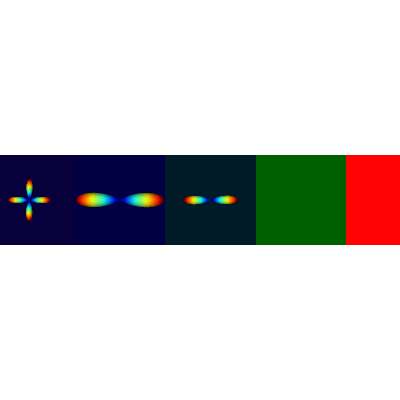

In [9]:
image = screenshot_fodf_grid(wm_fodf * 0.2, sphere, bg=vf_rgb,
                             title="msmt-CSD Model white matter fiber Orientation Probabilities")
Image(filename=image)

We do the same thing for our GM fODF. Since the amplitude is lower than for WM fODF, we keep a scaling of `1`.

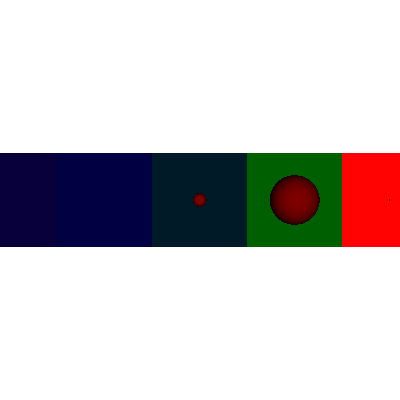

In [10]:
image = screenshot_fodf_grid(gm_fodf, sphere, bg=vf_rgb,
                             title="msmt-CSD Model gray matter fiber Orientation Probabilities")
Image(filename=image)

Finally, we do the same for CSF.

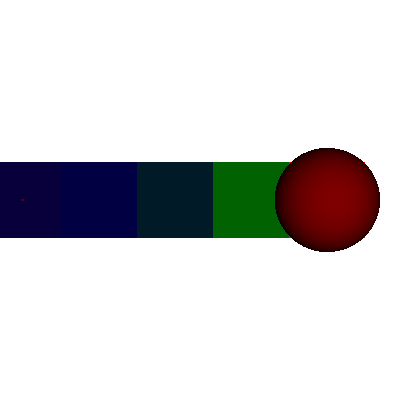

In [11]:
image = screenshot_fodf_grid(csf_fodf, sphere, bg=vf_rgb,
                             title="msmt-CSD Model CSF fiber Orientation Probabilities")
Image(filename=image)

## Diffusion propagator reconstruction

First let's demonstrate using `ShoreModel`.

In [11]:
from dipy.reconst.shore import ShoreModel

radial_order = 6
zeta = 700
lambdaN = 1e-8
lambdaL = 1e-8
asm = ShoreModel(gtab, radial_order=radial_order,
                 zeta=zeta, lambdaN=lambdaN, lambdaL=lambdaL)

asmfit = asm.fit(signal)

coeff = asmfit.shore_coeff
print('coeff.shape: ', coeff.shape)
print('coeff: \n', coeff)

dodf = asmfit.odf(sphere)

coeff.shape:  (50,)
coeff: 
 [ 3.27841356e+02 -1.78030480e+01  1.32063669e+00  8.98447479e+00
 -5.04075935e+01 -1.09932051e+00 -2.63356322e+01 -8.34430525e-01
 -4.35892243e-01 -5.13561442e+00  2.95601889e+00 -5.50881293e+00
  1.21893959e+00  5.57560070e-01  2.13623086e+00 -5.01012595e-01
  1.81257659e+00  1.62110042e+00 -6.35844687e-02  8.67875495e+00
 -7.50224216e-01 -6.39094139e+00 -2.92579760e-01  1.32667394e+01
 -9.96056847e-01 -1.06911330e+00  4.94022679e-01 -1.42111440e+00
  3.89668174e+00  6.61063362e-01 -3.14679376e+00 -9.81468053e-01
  9.48135733e+00 -3.74599769e-01  1.65584457e+00  2.40625449e-01
 -2.87268882e-01 -1.07969578e-01  6.89459547e-01  2.05382220e+00
 -2.91475136e-01 -8.75977518e-01  1.24313696e-01 -1.32768110e+00
  2.90558269e-01 -4.21998576e-02 -3.54683634e-01 -7.98427526e-01
 -7.74796829e-01 -8.40390801e-01]


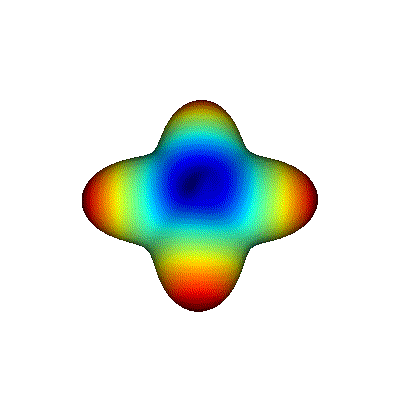

In [12]:
image = screenshot_animated_sf(dodf, sphere, title="SHORE model diffusion ODF")
Image(filename=image)

In [13]:
from dipy.core.geometry import sphere2cart, cart2sphere
radius = [0.010, 0.0125, 0.015, 0.0175, 0.02]
sphere_coord = sphere.vertices
pdf_all = np.zeros((len(radius), sphere_coord.shape[0]))
r, theta, phi = cart2sphere(sphere_coord[:, 0],
                            sphere_coord[:, 1],
                            sphere_coord[:, 2])

for i in range(len(radius)):
    x, y, z = sphere2cart(radius[i], theta, phi)
    r_points = np.vstack((x, y, z)).T
    pdf_all[i] = asmfit.pdf(r_points)

print('Return to Origin Probability (RTOP):', asmfit.rtop_signal())
print('Mean Squared Displacement (MSD):', asmfit.msd())

Return to Origin Probability (RTOP): 307157.03451309487
Mean Squared Displacement (MSD): 0.00011832895910289458


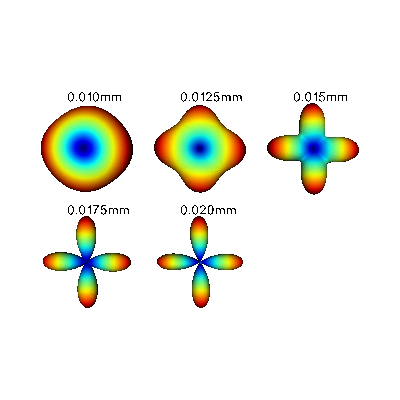

In [14]:
captions = ['0.010mm', '0.0125mm', '0.015mm', '0.0175mm', '0.020mm']
image = screenshot_grid_with_captions(pdf_all, sphere, captions,
                                      title='SHORE model diffusion isosurface with different radius')
Image(filename=image)

For more, see the Dipy galleries:
* https://dipy.org/documentation/1.3.0./examples_built/reconst_shore/#example-reconst-shore
* https://dipy.org/documentation/1.3.0./examples_built/reconst_shore_metrics/#example-reconst-shore-metrics
* https://dipy.org/documentation/1.3.0./examples_built/reconst_mapmri/#example-reconst-mapmri

Now let's use MAP MRI.

In [15]:
# With MAP MRI
from dipy.reconst.mapmri import MapmriModel

pos_cons = True
rad_order = 6
lap_reg = True

mapmri_model = MapmriModel(gtab,
                           positivity_constraint=pos_cons,
                           radial_order=rad_order,
                           laplacian_regularization=lap_reg)

mapmri_fit = mapmri_model.fit(signal)

coeff = mapmri_fit.mapmri_coeff
print('coeff.shape: ', coeff.shape)
print('coeff: \n', coeff)

dodf = mapmri_fit.odf(sphere)

coeff.shape:  (50,)
coeff: 
 [ 1.01621812e+00 -5.57020409e-02 -3.17579180e-03 -5.79191877e-02
 -7.26110365e-04  3.79160637e-03 -9.97012770e-02  4.71008778e-02
 -2.02009625e-02 -1.13093122e-03  2.90202416e-02  4.70678606e-02
  4.04300501e-03  1.31633065e-04  2.14037525e-03 -6.46561775e-03
  4.54103117e-02  2.02674582e-03  5.08231193e-02 -2.64394596e-03
  3.04910324e-04  6.54941425e-02  8.37902784e-05 -4.42889310e-03
 -3.05694515e-03  8.82105340e-05 -3.60443355e-04  3.48238832e-03
  2.67704356e-03 -8.36800434e-04 -5.08364734e-04 -3.20282897e-03
  1.31057170e-03 -4.48072755e-03  1.32004243e-03 -9.28526763e-04
 -7.08059848e-03 -6.70410129e-03  4.04335651e-03 -4.16012771e-03
  2.62712202e-03 -2.87546501e-03 -4.16340519e-04 -2.47161660e-03
 -9.89086241e-03  4.91232220e-04 -1.01621999e-02 -1.80990563e-03
 -2.70847080e-03  4.45895584e-03]


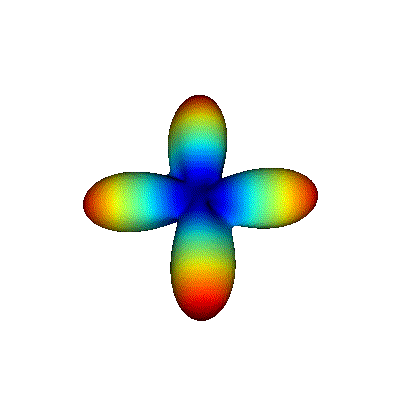

In [17]:
image = screenshot_animated_sf(dodf, sphere, title='MAP MRI model diffusion ODF')
Image(filename=image)

In [16]:
radius = [0.010, 0.0125, 0.015, 0.0175, 0.02]
sphere_coord = sphere.vertices
pdf_all = np.zeros((len(radius), sphere_coord.shape[0]))
r, theta, phi = cart2sphere(sphere_coord[:, 0],
                            sphere_coord[:, 1],
                            sphere_coord[:, 2])

for i in range(len(radius)):
    x, y, z = sphere2cart(radius[i], theta, phi)
    r_points = np.vstack((x, y, z)).T
    pdf_all[i] = mapmri_fit.pdf(r_points)

print('Return to Origin Probability (RTOP):', mapmri_fit.rtop())
print('Return to Axis Probability (RTAP):', mapmri_fit.rtap())
print('Return to Plane Probability (RTPP):', mapmri_fit.rtpp())
print('Mean Squared Displacement (MSD):', mapmri_fit.msd())

Return to Origin Probability (RTOP): 431951.56771688495
Return to Axis Probability (RTAP): 6379.994905219269
Return to Plane Probability (RTPP): 63.630681041903976
Mean Squared Displacement (MSD): 0.00012087565920717395


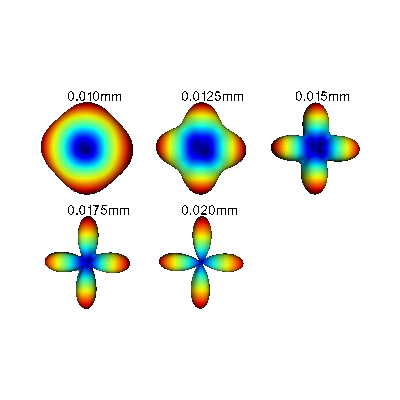

In [19]:
captions = ['0.010mm', '0.0125mm', '0.015mm', '0.0175mm', '0.020mm']
image = screenshot_grid_with_captions(pdf_all, sphere, captions,
                                      title='MAP MRI model diffusion isosurface with different radius')
Image(filename=image)